In [ ]:
pip install PyPortfolioOpt

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 1.3MB 13.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736236 sha256=61166826dba9729ce9ef25ac646579b07b57a5393702383107566c62597becd0
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
pip install pyfolio

     |████████████████████████████████| 92kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp37-none-any.whl size=88682 sha256=5701b01c172cfa2fd8608a7dc5e99cec6e2141f8259fc95641db0f5cc4f37cdd
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp37-none-any.whl size=39780 sha256=93e802397cb3ffe9d74fd5e9f0404fe4bc52764e627bbb61eecde99782f50769
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


In [ ]:
#Import necessary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import os
import pyfolio as pf

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [ ]:
#Loading and preparing data: 
index_df=pd.read_excel('/data_to_feed.xlsx')
pd.to_datetime(index_df['Unnamed: 0'])
index_df=index_df.set_index('Unnamed: 0')
index_wo_hedge_df=index_df.drop('EURUSD heding', axis=1)
fx_hedge=index_df['EURUSD heding']

In [ ]:
#Block of code that contains inputs for optimization and backtesting:
opt_period=252 # use prior year to optimize portfolio, 1 year (252); 2 years (504), 3 years (756)
end_point=len(index_wo_hedge_df)
reb_freq=5 #rebalancing frequency, 1 day (1); 1 week (5); 1 month (22); 3 months (66); 6 months (132)
moving_lower_bound=0
#create an empty dataframe to save portfolio weights
weights_df=pd.DataFrame(columns=index_wo_hedge_df.columns)

#Define portfolio constraints:
sector_mapper={
    'Equity, global':'equity',
    'Equity, emerging': 'equity',
    'cash index': 'cash',
    'Bonds, EU govies': 'eu govies',
    'Bonds, OECD corps IG': 'corps and non eu' , 
    'Bonds, govies, CEE':'eu govies' ,
    'Bonds, corps, CEE, USD (should be "hedged")': 'corps and non eu', 
    'Bonds, govies, EM': 'corps and non eu', 
    'Bonds, Germany long duration': 'eu govies', 
    'Gold': 'Gold'
}
sector_lower={'cash':0.03}
sector_upper = {
    'equity':0.2,
    'cash':0.0300000001,
    'corps and non eu':0.3
}



In [ ]:
#Block of code to optimize the portoflio and back test it: 
for moving_upper_bound in range(opt_period, end_point, reb_freq): 
  
  #Extract data for certain period to use for the optimization:
  data_to_opt=index_wo_hedge_df.iloc[moving_lower_bound:moving_upper_bound]

  #Optimize the portfolio using extracted data period: 
  mu=expected_returns.mean_historical_return(data_to_opt)
  sigma=risk_models.sample_cov(data_to_opt)
    #create object to optimize:
  ef=EfficientFrontier(mu, sigma)
  ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  raw_weights=ef.max_sharpe()
  clean_weights=ef.clean_weights()

  #Add weights to the DataFrame, accounting for the rebalancing period: 
  for period in range(reb_freq):
    weights_df=weights_df.append(clean_weights, ignore_index=True)

  #change moving_lower_bound to account for the change of the period used for the optimization: 
  moving_lower_bound+=reb_freq

#Change col names add to make it more distinguishable:
weights_df.rename(columns={'Equity, global': 'Equity, global weight',
                           'Equity, emerging': 'Equity, emerging weight', 
                           'cash index': 'cash index weight' , 
                           'Bonds, EU govies': 'Bonds, EU govies weight',
                           'Bonds, OECD corps IG':'Bonds, OECD corps IG weight' , 
                           'Bonds, govies, CEE': 'Bonds, govies, CEE weight' ,
                           'Bonds, corps, CEE, USD (should be "hedged")': 'Bonds, corps, CEE, USD weight', 
                           'Bonds, govies, EM': 'Bonds, govies, EM weight',
                           'Bonds, Germany long duration': 'Bonds, Germany long duration weight', 
                           'Gold': 'Gold weight'}, inplace=True)

#Add date column to the weights and use it as index col:

date_time=pd.Series(index_wo_hedge_df.index)

weights_df['date_time']=date_time.iloc[opt_period:].values
weights_df=weights_df.set_index('date_time')
#Join all DFs into one: 
final_index_df=pd.concat([index_wo_hedge_df.iloc[opt_period:].pct_change(), weights_df, fx_hedge[opt_period:]], axis=1)
final_index_df=final_index_df.drop(final_index_df.index[0], axis=0)

In [ ]:
#Block of code used to calculate portfolio performance - I need to fix it: 
# PLEASE, USE CODE FFROM THE NEXT CELL:
indexing=int((len(final_index_df.columns))/2+1)
final_index_df.columns[:indexing]
portfolio_df=pd.DataFrame()
index_weight=indexing-1
final_data_to_hedge=final_index_df[['Bonds, corps, CEE, USD (should be "hedged")','Bonds, corps, CEE, USD weight', 'EURUSD heding' ]]
final_data_no_hedge= final_index_df.drop(final_index_df[['Bonds, corps, CEE, USD (should be "hedged")','Bonds, corps, CEE, USD weight', 'EURUSD heding' ]], axis=1)

# Calculate portfolio performance attributed by assets that do nt need to be hedged:
for i in range(indexing):
  asset_perf=final_data_no_hedge[final_data_no_hedge.columns[i]]*final_data_no_hedge[final_data_no_hedge.columns[index_weight]]
  portfolio_df=pd.concat([portfolio_df,asset_perf], axis=1)
  index_weight+=1

#Add asset performance which had to be hedged: 


IndexError: ignored

In [ ]:
#Block of code used to calculate portfolio performance - working code:
portfolio_df=pd.DataFrame()
portfolio_df=pd.concat([portfolio_df, 
           final_index_df['Equity, global']*final_index_df['Equity, global weight'],
           final_index_df['Equity, emerging']*final_index_df['Equity, emerging weight'],
           final_index_df['cash index']*final_index_df['cash index weight'],
           final_index_df['Bonds, EU govies']*final_index_df['Bonds, EU govies weight'],
           final_index_df['Bonds, OECD corps IG']*final_index_df['Bonds, OECD corps IG weight'],
           final_index_df['Bonds, govies, CEE']*final_index_df['Bonds, govies, CEE weight'],
           final_index_df['Bonds, corps, CEE, USD (should be "hedged")']*final_index_df['Bonds, corps, CEE, USD weight']*(1-final_index_df['EURUSD heding']/100),
           final_index_df['Bonds, govies, EM']*final_index_df['Bonds, govies, EM weight'],
           final_index_df['Bonds, Germany long duration']*final_index_df['Bonds, Germany long duration weight'],
           final_index_df['Gold']*final_index_df['Gold weight']
           
], axis=1)

portfolio_df['portfolio_perf']=portfolio_df.sum(axis=1)

In [ ]:
portfolio_df.to_excel('/portfolio_df_MinVol_portf_perf (exp mu and sigma).xlsx')
final_index_df.to_excel('/final_index_MinVol_weights (exp mu and sigma).xlsx')

Start date,2005-12-20
End date,2020-05-08
Total months,178
,Backtest
Annual return,5.2%
Cumulative returns,113.6%
Annual volatility,5.0%
Sharpe ratio,1.04
Calmar ratio,0.43
Stability,0.98
Max drawdown,-12.2%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.21,2006-05-11,2006-06-13,2007-10-09,369
1,11.23,2015-04-16,2015-08-25,2017-09-18,633
2,10.63,2011-08-22,2011-12-29,2012-05-31,204
3,8.28,2020-02-20,2020-03-19,NaT,NaN
4,4.60,2018-01-08,2018-10-11,2019-01-24,274


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

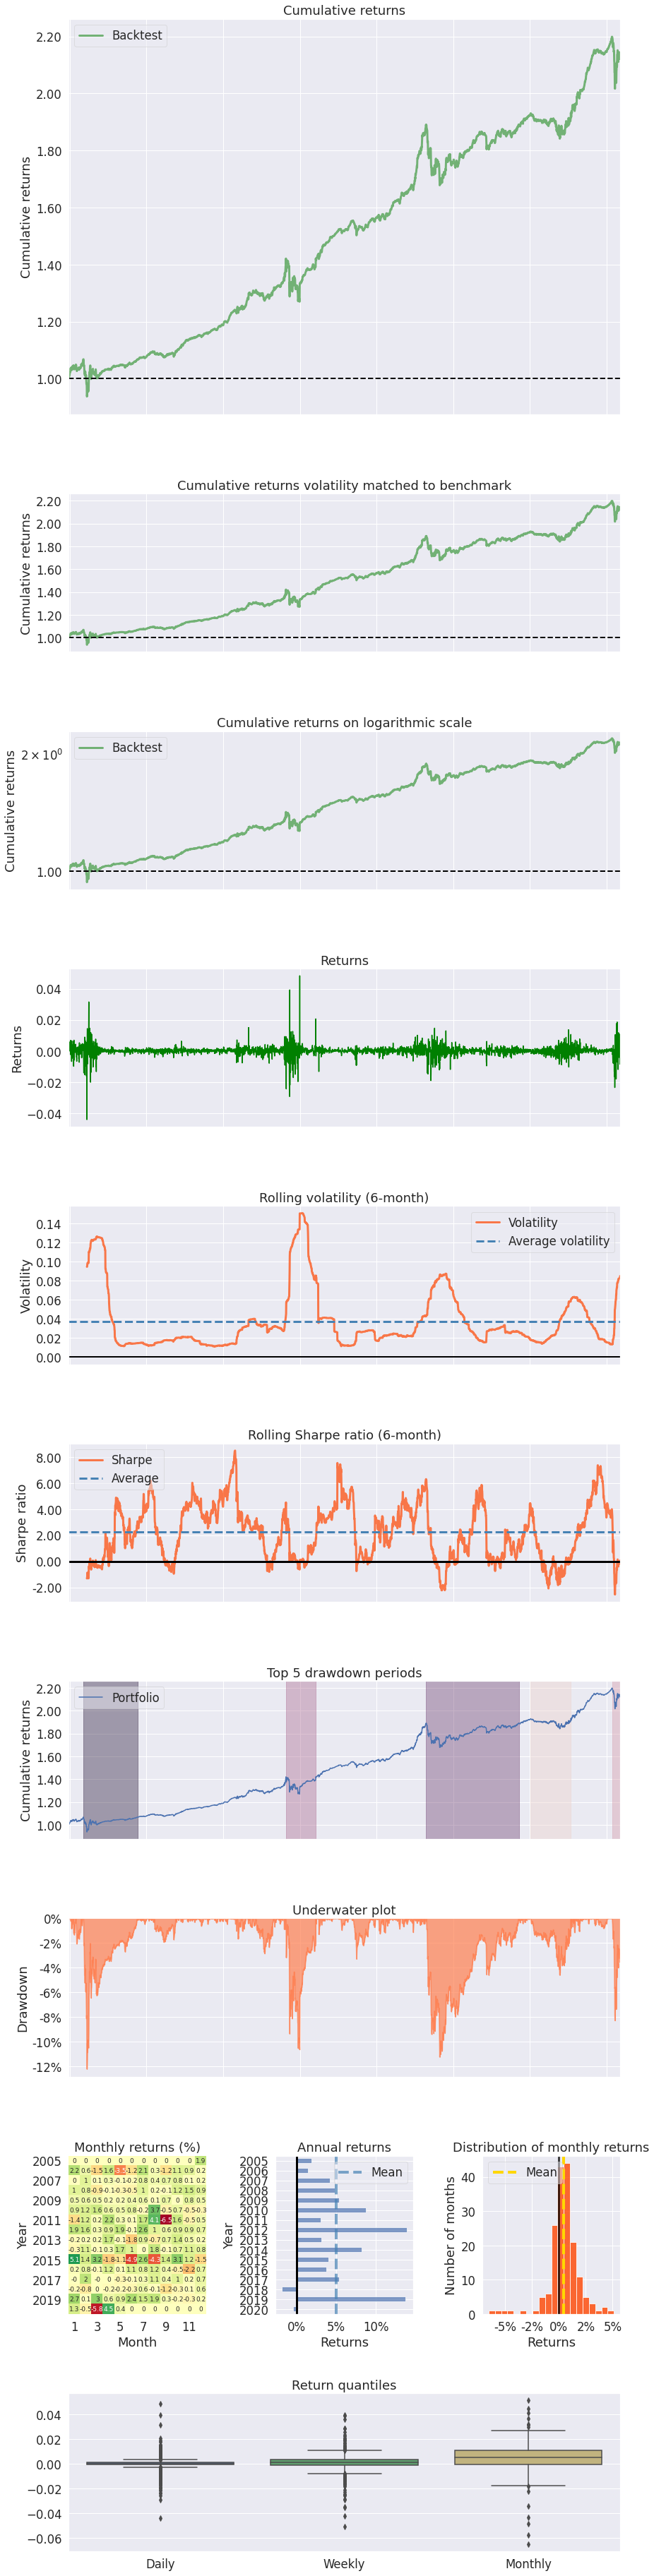

In [ ]:
pf.create_returns_tear_sheet(portfolio_df['portfolio_perf'])